In [142]:
import pickle
import pandas as pd
import numpy as np
import scipy.stats as ss
import seaborn as sns
sns.set()
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
title_fontsize = 20
xlabel_fontsize = 18
ylabel_fontsize = 18
legend_fontsize = 14
ticks_fontsize = 18
figure_format = "pdf"
%matplotlib inline

## Load metadata for samples and subjects in GTEx

In [143]:
# load sample metadata: 18220 samples, 73 technnical parameters
sampleMetaData = pd.read_csv('/om2/user/elvira/src/data/GTEx_v8/annotations/GTEx_Analysis_2017-06-05_v8_Annotations_SampleAttributesDS.txt', sep = '\t', header = 'infer', index_col=0)
# load sample metadata: 948 people, 174 phenotipic parameters
subjectMetaData = pd.read_csv('/om2/user/elvira/src/data/GTEx_v8/annotations/GTEx_Analysis_2017-06-05_v8_Annotations_SubjectPhenotypesDS.txt', sep = '\t', header = 'infer', index_col=0)

/home/dockeruser/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Load data by tissue

In [144]:
def load_data(tissue):
    """ Load gene expression for each tissue.
    
     Parameters
    ----------
    tissue: one of GTEx tissues
    
     Outputs
    ----------
    data : pd.DataFrame
        genes x samples dataframe
    age : np.array, int
        age of each subject who provided the sample for the tissue
    SMRIN : np.array, float
        RIN number (RNA integrity number) for each sample
    SMTSISCH : np.array, int
        total ischemic time for each sample
    """
    
    print(tissue)
    data_p_file = "/om2/user/elvira/src/data/GTEx_v8/rna_seq/Expr_by_tissue/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm_"+\
    str(tissue)+".pkl"
    data = pd.read_pickle(data_p_file)
    gene_ids = data['Name']
    gene_names = data['Description']
    data.index = gene_ids
    data = data.iloc[:,2:]
    print(data.shape[1], " samples, ", data.shape[0], "genes")
    
    # filter out genes that are expressed in fewer than 10% of samples
    data = data[(data.T == 0).sum()<0.1*data.shape[1]]
    print(str(len((data.T == 0).sum()>0.1*data.shape[1])) + " genes filtered out")
    
    # filter out samples that express fewer than 10% of genes
    data = data.loc[:,data.columns[(pd.isna(data)).sum()<0.1*data.shape[0]]]
    print(str(len(data.columns[(pd.isna(data)).sum()>0.1*data.shape[0]])) + " samples filtered out")
    
    # load age, SNRIN, and SMTSUSCH values for each subject
    subject_ids = [subject_id.split("-")[0]+"-"+subject_id.split("-")[1] for subject_id in \
     data.columns.tolist()]
    age = [np.asarray(subjectMetaData.loc[subjectMetaData.index==subject_id,'AGE'])[0] \
                   for subject_id in subject_ids]
    SMRIN = [np.asarray(sampleMetaData.loc[sampleMetaData.index==sample_id,'SMRIN'])[0] \
                   for sample_id in data.columns.tolist()]
    SMTSISCH = [np.asarray(sampleMetaData.loc[sampleMetaData.index==sample_id,'SMTSISCH'])[0] \
                   for sample_id in data.columns.tolist()]
    return data, age, SMRIN, SMTSISCH

## Load and filter data

Choosing tissues that have > 800 samples (8 tissues in GTEx). It is arbitrary, so you can choose a lower threshold to study more tissues if your age prediciton model works even for fewer samples

In [155]:
tissues = ['Muscle',
 'Blood Vessel',
 'Brain',
 'Blood',
 'Skin',
 'Esophagus',
 'Heart',
 'Adipose Tissue']

In [165]:
data = {}
age = {}
SMRIN = {}
SMTSISCH = {}

for tissue in tissues:
    data[tissue], age[tissue], SMRIN[tissue], SMTSISCH[tissue] = load_data(tissue)

Muscle
804  samples,  56200 genes
19544 genes filtered out
0 samples filtered out
9098 genes with no correlation with age
first 50 components explain 0.9998112297541027 variability
(803, 803)
Blood Vessel
1335  samples,  56200 genes
21218 genes filtered out
0 samples filtered out
8429 genes with no correlation with age
first 50 components explain 0.9984083167856995 variability
(1335, 1335)
Brain
2642  samples,  56200 genes
22135 genes filtered out
0 samples filtered out
6971 genes with no correlation with age
first 50 components explain 0.999767050196433 variability
(2642, 2642)
Blood
1702  samples,  56200 genes
19334 genes filtered out
0 samples filtered out
7341 genes with no correlation with age
first 50 components explain 0.9936064012015714 variability
(929, 929)
Skin
1811  samples,  56200 genes
20767 genes filtered out
0 samples filtered out
12502 genes with no correlation with age
first 50 components explain 0.9987557180550182 variability
(1809, 1809)
Esophagus
1451  samples,  56

## Correct for covariates and remove outliers

### Find genes with weak correlation with age

In [5]:
def define_non_age_related_genes(data, age):
    rhos = np.zeros((len(data.index.tolist())))
    spear_pvals = np.zeros((len(data.index.tolist())))
    for i, gene in enumerate(data.index.tolist()):
        rhos[i], spear_pvals[i] = ss.spearmanr(data.loc[gene,:], age, nan_policy = 'omit')
    gene_idxs = range(data.shape[0])
    gene_idxs = [gene_idx for gene_idx in gene_idxs if spear_pvals[gene_idx]>0.01]
    print(str(len(gene_idxs)) + " genes with no correlation with age")
    non_aging_expr = data.iloc[gene_idxs,:]
    return(non_aging_expr)

### Perform SVD (singular value decomposition) of non-age related gene expression

In [6]:
def svd(non_aging_expr, n_comp = 50):
    u, s, vh  = np.linalg.svd(non_aging_expr.transpose())
    d2 = s**2
    print("first " + str(n_comp) + " components explain " + str(d2[:n_comp].sum()/d2.sum()) + " variability")
    print(u.shape)
    u_top_10 = u[:n_comp,:]
    x_0 = u_top_10*s
    return(x_0)

### Regress out non-age-related covariates

In [7]:
import sklearn.linear_model as linear_model
def linear_regression(x_train, y_train):
    ols = linear_model.LinearRegression()
    model = ols.fit(x_train, y_train)
    return ols.coef_, ols.intercept_, ols.predict(x_train)

def regress_covariates(data, x_0):
    coeffs, intercepts, prediction = linear_regression(x_0.transpose(), data.transpose()) 
    residual = (data.transpose()-np.asmatrix(x_0.transpose())*coeffs.transpose()).transpose()
    return residual

### Exclude non-age-related genes

In [8]:
def exclude_non_age_related_genes(residual, gene_idxs):
    aging_gene_idxs = [i for i in range(len(residual.index)) if i not in gene_idxs]
    residual_aging = residual.iloc[aging_gene_idxs,:]
    return(residual_aging)

### Remove outliers

In [168]:
def plot_PCA(X, ax, tissue):
    for i in range(len(X[:, 0])):
        ax.scatter(X[i, 0], X[i, 1], color = 'C0')
    ax.set_title(tissue, fontsize = title_fontsize)
    ax.set_xlabel('PC1', fontsize = xlabel_fontsize)
    ax.set_xlabel('PC2', fontsize = ylabel_fontsize)

In [169]:
from sklearn import decomposition
def detect_outliers(residual_aging, tissue):
    pca = decomposition.PCA(n_components=2)
    X = residual_aging.transpose().copy()
    pca.fit(X)
    X = pca.transform(X)
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    plot_PCA(X, ax, tissue)
    q1 = pd.DataFrame(X[:, 0]).quantile(0.999)
    q2 = pd.DataFrame(X[:, 1]).quantile(0.999)
    print(q1[0])
    print(q2[0])
    residual_no_outliers = residual_aging.iloc[:,np.asarray([j for j in \
                                                             range(len(residual_aging.columns)) \
                                                             if X[j, 0] < q1[0] and X[j, 1] < q2[0]])]
    print(str(residual_aging.shape[0] - residual_no_outliers.shape[0]) + " outliers removed")
    
    subj_ids = [subject_id.split("-")[0]+"-"+subject_id.split("-")[1] for subject_id in \
                residual_no_outliers.columns.tolist()]
    ages = [np.asarray(subjectMetaData.loc[subjectMetaData.index==subject_id,'AGE'])[0] \
                   for subject_id in subj_ids]
    SMRINs = [np.asarray(sampleMetaData.loc[sampleMetaData.index==sample_id,'SMRIN'])[0] \
                   for sample_id in residual_no_outliers.columns.tolist()]
    SMTSISCHs = [np.asarray(sampleMetaData.loc[sampleMetaData.index==sample_id,'SMTSISCH'])[0] \
                   for sample_id in residual_no_outliers.columns.tolist()]
    return residual_no_outliers, ages, SMRINs, SMTSISCHs

Muscle
66990.76865243577
76452.38636553995
0 outliers removed
Blood Vessel
103462.36856554463
24082.783326096178
0 outliers removed
Brain
116890.1781424671
111974.90145022472
0 outliers removed
Blood
467045.9413724076
166901.62726780731
0 outliers removed
Skin
62994.590302017576
57825.44173442688
0 outliers removed
Esophagus
106440.31843278966
75860.32292213576
0 outliers removed
Heart
125860.60729632348
77337.94027949733
0 outliers removed
Adipose Tissue
108310.23501235274
54357.29603142904
0 outliers removed


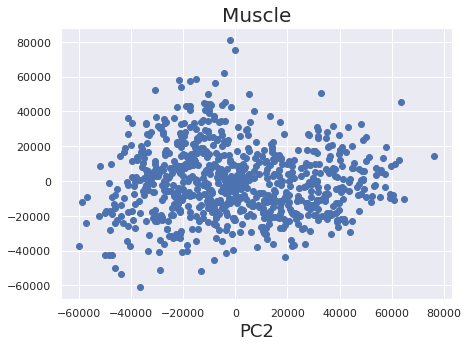

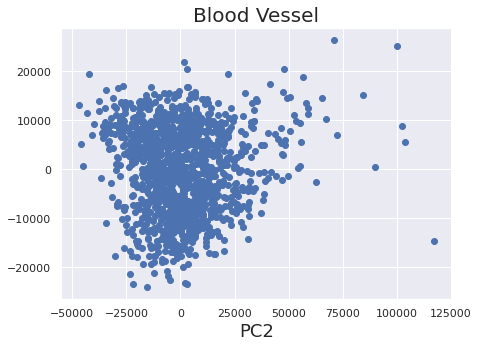

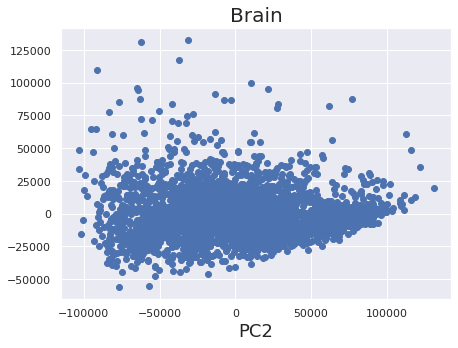

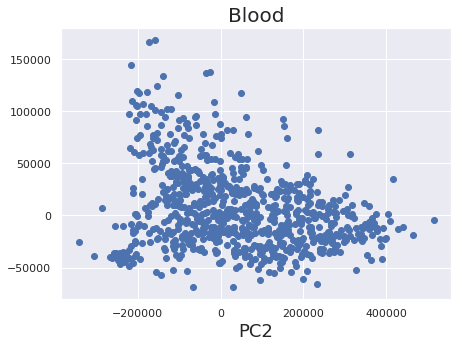

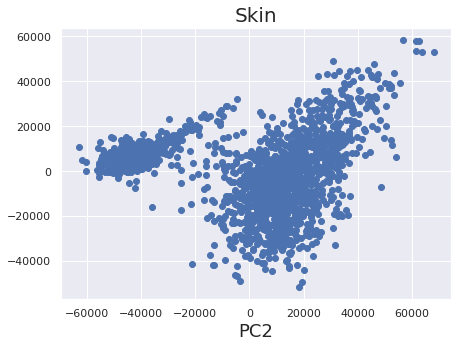

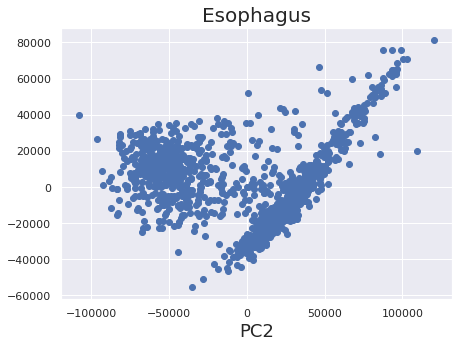

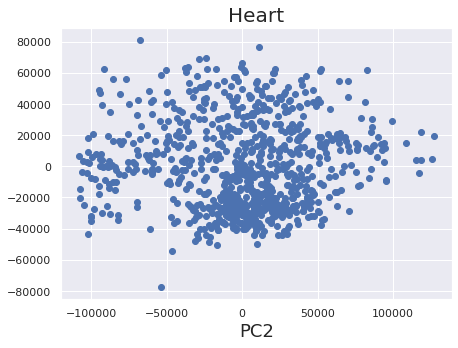

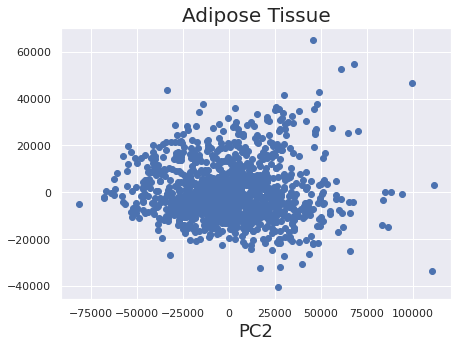

In [176]:
non_aging_expr = {}
x_0 = {}
residual = {}
residual_aging = {}
residual_no_outliers = {}
ages = {}
SMRINs = {}
SMTSISCHs = {}

for i, tissue in enumerate(tissues):
        print(tissue)
        
        non_aging_expr[tissue] = define_non_age_related_genes(data[tissue], age[tissue])
        x_0[tissue] = svd(non_aging_expr[tissue], n_comp=50)
        residual[tissue] = regress_covariates(data[tissue], x_0[tissue])
        residual_aging[tissue] = exclude_non_age_related_genes(residual[tissue], \
                                                               non_aging_expr[tissue].index.tolist())
        residual_no_outliers[tissue], ages[tissue], SMRINs[tissue], SMTSISCHs[tissue] = \
        detect_outliers(residual_aging[tissue], tissue)

## Build the model predicting age with Lasso

In [257]:
def split_train_valid_test(num_examples,training_proportion,validation_proportion,test_proportion):
    assert training_proportion<=1.0
    assert validation_proportion<=1.0
    assert test_proportion<=1.0
    assert (training_proportion+validation_proportion+test_proportion)<=1.0

    idx_shuff=np.random.RandomState(seed=77).permutation(range(num_examples))

    training_threshold=int(num_examples*training_proportion)
    validation_threshold=int(num_examples*(training_proportion+validation_proportion))

    training=range(training_threshold)
    validation=range(training_threshold,min(validation_threshold,num_examples))
    test=range(validation_threshold,num_examples)

    return(idx_shuff[list(training)],idx_shuff[list(validation)],idx_shuff[list(test)])

In [288]:
def fit_lasso_model(residual_no_outliers, ages, tol):
    """ Build an age predictor with the lasso model and estimate its performance.
    
     Parameters
    ----------
    residual_no_outliers: pd.DataFrame
        gene expression for a tissue after all preprocessing: \
        - QC of genes and samples
        - regression of technical and phenotipic covariates explaining most of the variability \
            (except age, we need this variability, so we don't regress it out)
        - removal of outliers
    ages : np.array, int
        ages of samples in a tissue gene expression matrix
    tol : float, default=1e-4
        tolerance for the optimization in the lasso model
        
     Outputs
    ----------
    genes : np.array, str
        genes that are predictive of the age according to the lasso model
    score : float
        coefficient of determination R^2 of the prediction
    pearsonr : float
        Pearson's correlation coefficient
    ages_test : np.array, int
        true ages for the test set
    ages_pred_test : np.array, int
        predicted ages for the test set
    """
    ages_all = ages
    
    # built the age prediction model with the lasso algorithm with cross-validation
    X = residual_no_outliers.transpose()
    y = ages_all
    
    # you can try a different model here
    reg = LassoCV(cv=5, random_state=0, tol = tol).fit(X, y)
    score = reg.score(X, y)
    
    # select genes predictive of age chosen by the lasso model
    genes = [residual_no_outliers.index[i] for i in range(residual_no_outliers.shape[0]) if reg.coef_[i]!=0]
    expr_sel_genes = residual_no_outliers.loc[genes,:]
    
    # split dataset into training, validation, and test sets
    train, test, val = split_train_valid_test(residual_no_outliers.shape[1], 0.7, 0.3, 0)
    ages_train = np.asarray([ages[i] for i in train])
    ages_test = np.asarray([ages[i] for i in test])
    
    # calculate age predicted by the model and 
    # correlation of the predicted age with chronological age
    coeffs_final, intercepts_final, prediction_final = \
    linear_regression(expr_sel_genes.iloc[:,train].transpose(), ages_train) 
    ages_pred_test = intercepts_final + \
    np.asmatrix(expr_sel_genes.iloc[:,test].transpose())*np.asmatrix(coeffs_final).transpose()
    ages_pred_test = [np.asarray(age)[0][0] for age in ages_pred_test]
    pearsonr = ss.pearsonr(ages_pred_test, ages_test)
    print(pearsonr)
    
    # plot clock prediction
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    ax.scatter(ages_test, ages_pred_test)
    ax.set_xlabel("Chronological age, years", fontsize = xlabel_fontsize)
    ax.set_ylabel("Predicted age, years", fontsize = ylabel_fontsize)
    ax.set_title(str(tissue),  fontsize = title_fontsize)
    textstr = "Pearson's r=" + str(round(pearsonr[0],2))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    plt.tight_layout()
    pp = "/om2/user/elvira/figures/Aging_clock/Clock_" + str(tissue) + figure_format
#     plt.savefig(pp, format = figure_format)
    return(genes, score, pearsonr, ages_test, ages_pred_test)

Muscle
(0.5436034774880136, 6.226426618766272e-20)
Blood Vessel
(0.7737109836752439, 6.578723994490761e-81)


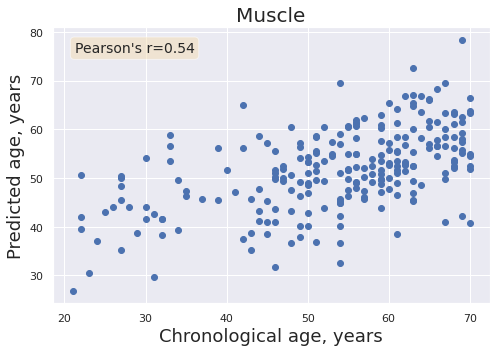

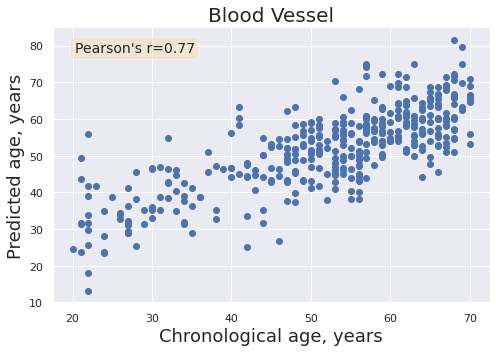

In [291]:
genes_clock = {}
score = {}
pearson_corr = {}
prediction = {}
true = {}
for i, tissue in enumerate(tissues[:2]):
    print(tissue)
    genes_clock[tissue], score[tissue], pearson_corr[tissue], true[tissue], prediction[tissue] = \
    fit_lasso_model(residual_no_outliers[tissue], ages[tissue], tol=0.1)

# Additional analysis

### Comparing prediction accuracy for different tissues

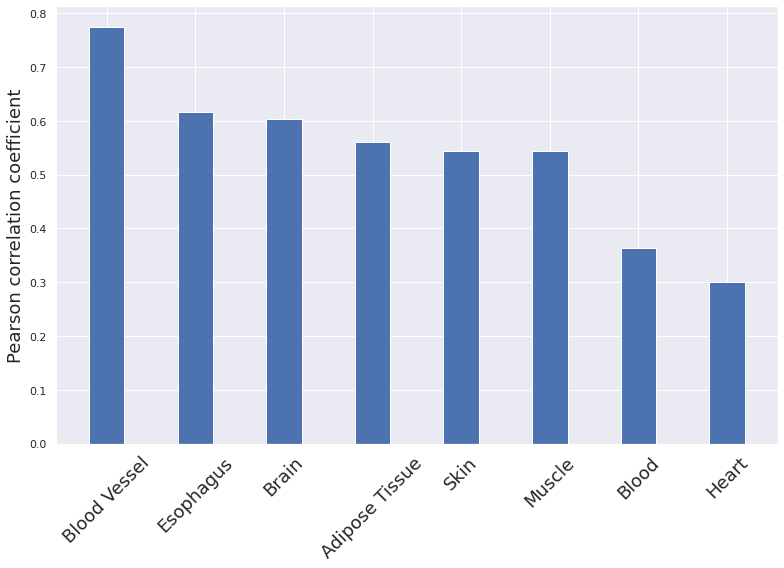

In [287]:
fig, ax = plt.subplots(figsize=(11,8))
n=2
x_coords = np.arange(0,n*len(tissues), n)
ax.set_xticks(np.arange(0,n*len(tissues), n))
coeff = np.asarray([pearson_corr[tissue][0] for tissue in tissues])
ax.set_xticklabels([tissues[i] for i in np.argsort(coeff)[::-1]], rotation=45, fontsize=xlabel_fontsize)
ax.bar(x_coords, coeff[np.argsort(coeff)[::-1]], \
    color='C0', edgecolor='white')
ax.set_ylabel('Pearson correlation coefficient', fontsize=ylabel_fontsize) 
plt.tight_layout()
pp = "/Users/elvirakinzina/src/Aging_clock/Pictures/Number_of_genes_and_correlation." + figure_format
# plt.savefig(pp, format = figure_format)

## Define most important covariates
These could be included in the model or regressed out to improve age prediction

In [246]:
def gaussian_project(data, standardize=True, noise=1e-6):
    """ Project each row onto gaussian with matched mean, stdev 

    standardize : bool
        project each row onto N(0, 1), otherwise use N(mu_row, sigma_row),
        where mu_row is the mean of the row and sigma_row is the standard
        deviation
    noise : float
        add random noise drawn from interval (0, noise) to break ties
    """
    # add random noise to break ties
    err = np.random.random(data.shape) * noise
    data = data + err

    ppt = data.rank(axis=1) / (float(data.shape[1])+1.)
    if standardize:
        df = pd.DataFrame(ss.norm.ppf(ppt), index=ppt.index, 
                          columns=ppt.columns)
    else:
        mu = data.mean(axis=1)
        sigma = data.std(axis=1)
        df = {}
        for r in ppt.index:
            df[r] = pd.Series(ss.norm.ppf(ppt.loc[r], loc=mu.loc[r],
                                          scale=sigma.loc[r]), index=ppt.columns)
        df = pd.DataFrame(df).T
    return df
def find_covars_corr_with_first_2_pcs(tissue, data, ax):
        dt = data.copy()
        dt_g = gaussian_project(dt)

        pca = PCA().fit(dt_g)

        # extract principal components
        comps = pd.DataFrame(pca.components_.T, index=dt_g.columns,
                             columns=['PC%i' % (i+1) for i in range(len(pca.components_))])
        
        # choose potential important covariates (add whatever you are interesred in)
        covars = ['SMRIN', 'SMTSISCH', 'TRISCHD', 'ETHNCTY', 'RACE', 'AGE', 'BMI', 'SMNTRNRT', 'DTHRFG', 'DTHVNT', \
                  'SMATSSCR', 'SMALTALG', 'DTHHRDY', 'DTHHRDY']
        print('components', pca.explained_variance_ratio_[0:10])
    
        if np.fabs(sum(pca.explained_variance_ratio_)-1)>0.1:
            print('sum', sum(pca.explained_variance_ratio_))
        
        covs_r = {}
        covs_p = {}
        for pc in ['PC{}'.format(i+1) for i in range(10)]:
            _r = {}
            _p = {}
            for cv in covars:
                if cv in sampleMetaData.columns:
                    covar_vals = np.asarray(sampleMetaData.loc[comps.index, cv])
                elif cv in subjectMetaData.columns:
                    sample_subject_ids = [index.split("-")[0] + "-" + index.split("-")[1] \
                                 for index in list(comps.index)]
                    covar_vals = np.asarray(subjectMetaData.loc[sample_subject_ids, cv])
                _r[cv], _p[cv] = ss.pearsonr(covar_vals[np.isfinite(covar_vals)], \
                                             comps.loc[np.isfinite(covar_vals), pc])
                covs_r[pc] = pd.Series(_r)
                covs_p[pc] = pd.Series(_p)
        covs_r = pd.DataFrame(covs_r).loc[:, ['PC{}'.format(i+1) for i in range(10)]]
        covs_p = pd.DataFrame(covs_p).loc[:, ['PC{}'.format(i+1) for i in range(10)]]

        covarsMain = [covar for covar in covars if (covs_p.loc[covar,:][0:10]<0.05).any()==True]
        first_2_pcs_pars = [covar for covar in covars if (covs_p.loc[covar,:][0:2]<0.05).any()==True]
        ax.set_title(tissue)
        sns.heatmap(-1*np.log10(covs_p.loc[covarsMain,:]), ax=ax, vmax=10, annot=True, fmt=".1f")
        return(first_2_pcs_pars)

components [0.15353368 0.07795946 0.04821096 0.04059566 0.03721666 0.03060337
 0.02729832 0.02431732 0.01696272 0.01645231]


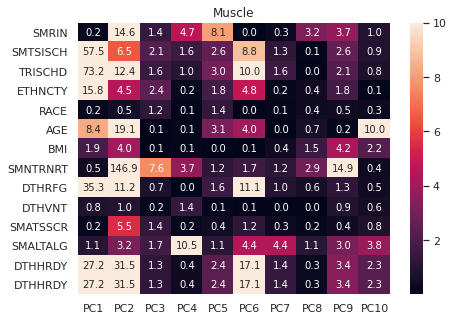

In [249]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
first_2_pcs_pars = find_covars_corr_with_first_2_pcs('Muscle', data['Muscle'], ax)

components [0.2983426  0.10469608 0.03977862 0.03454156 0.03010902 0.02665038
 0.02177791 0.01891883 0.01612484 0.01388074]


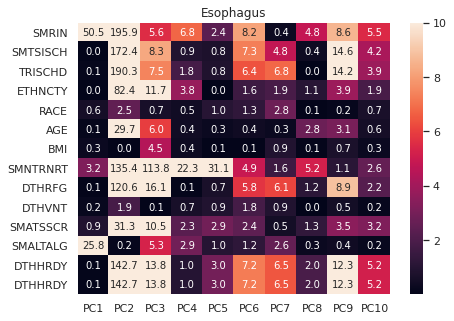

In [256]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
first_2_pcs_pars = find_covars_corr_with_first_2_pcs('Esophagus', data['Esophagus'], ax)

## Color PCA by parameter (age, RNA quality, ischemic time before) values to explore important parameters for each tissue

You can look at other technical or phenotypic covariates to find those that can possibly explain PCA patterns for tissues that clearly have clusters: skin and esophagus

In [193]:
def plot_pca_colored_by(data, parameter):
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    pca = decomposition.PCA(n_components=2)
    X = data.transpose().copy()
    pca.fit(X)
    y = np.asarray(parameter)
    X = pca.transform(X)
    y_no_na = y[np.where(np.isfinite(y))]
    y_min = np.min(y_no_na)
    y_max = np.max(y_no_na)
    
    for i in range(len(X[:, 0])):
        if np.isfinite(y[i]):
            alpha = float((y[i]-y_min)/float(y_max-y_min))
            ax.scatter(X[i, 0], X[i, 1], color = 'green', alpha = alpha, s=15)

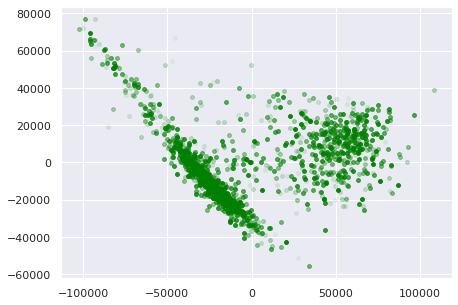

In [192]:
plot_pca_colored_by(residual_no_outliers["Esophagus"], SMTSISCH["Esophagus"])

## Sample size of each tissue
I chose top 8 tissues for the analysis above

In [153]:
# tissues = list(set(sampleMetaData['SMTS']))
# sample_num = dict()
# for tissue in tissues:
#         data[tissue], age[tissue], SMRIN[tissue], SMTSISCH[tissue] = load_data(tissue)
#         sample_num[tissue] = data[tissue].shape[1]
# out_file = "/om2/user/elvira/src/data/GTEx_v8/rna_seq/Tissues_sample_numbers.pkl"
# with open(out_file, "wb") as f:
#     pickle.dump(sample_num,f,pickle.HIGHEST_PROTOCOL)

[Text(0, 0, 'Brain'),
 Text(0, 0, 'Skin'),
 Text(0, 0, 'Esophagus'),
 Text(0, 0, 'Blood Vessel'),
 Text(0, 0, 'Adipose Tissue'),
 Text(0, 0, 'Blood'),
 Text(0, 0, 'Heart'),
 Text(0, 0, 'Muscle'),
 Text(0, 0, 'Colon'),
 Text(0, 0, 'Thyroid'),
 Text(0, 0, 'Nerve'),
 Text(0, 0, 'Lung'),
 Text(0, 0, 'Breast'),
 Text(0, 0, 'Testis'),
 Text(0, 0, 'Stomach'),
 Text(0, 0, 'Pancreas'),
 Text(0, 0, 'Pituitary'),
 Text(0, 0, 'Adrenal Gland'),
 Text(0, 0, 'Prostate'),
 Text(0, 0, 'Spleen'),
 Text(0, 0, 'Liver'),
 Text(0, 0, 'Small Intestine'),
 Text(0, 0, 'Ovary'),
 Text(0, 0, 'Salivary Gland'),
 Text(0, 0, 'Vagina'),
 Text(0, 0, 'Uterus'),
 Text(0, 0, 'Kidney'),
 Text(0, 0, 'Cervix Uteri'),
 Text(0, 0, 'Fallopian Tube')]

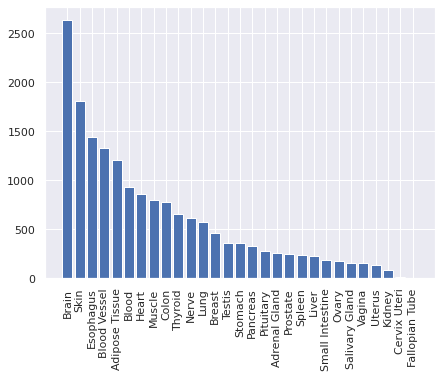

In [82]:
sample_num = pd.read_pickle("/om2/user/elvira/src/data/GTEx_v8/rna_seq/Tissues_sample_numbers.pkl")
tissues = list(sample_num.keys())
sample_numbers = np.asarray([sample_num[tissue] for tissue in tissues])
indices = np.argsort(sample_numbers)[::-1]
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.bar(range(len(tissues)), sample_numbers[indices])
ax.set_xticks(range(len(tissues)))
ax.set_xticklabels([tissues[index] for index in indices], rotation = 90)

## Plot sample age distribution for each tissue
Most samples are from elderly since they die more often

/home/dockeruser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


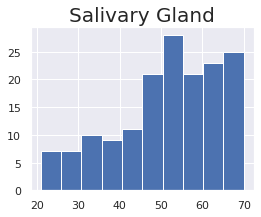

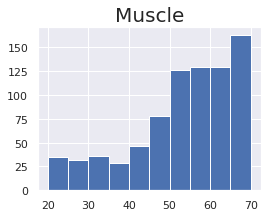

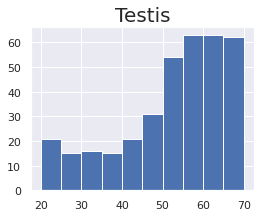

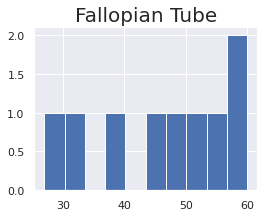

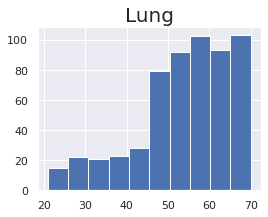

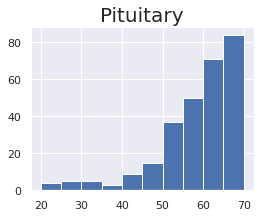

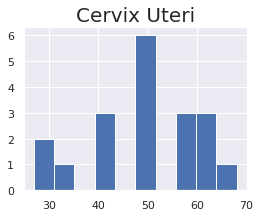

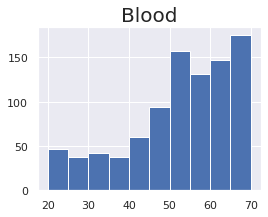

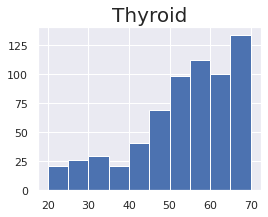

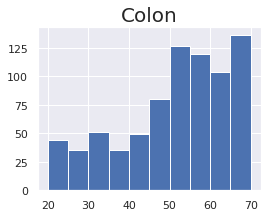

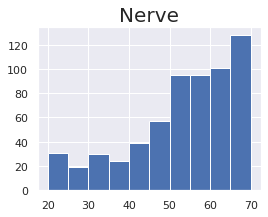

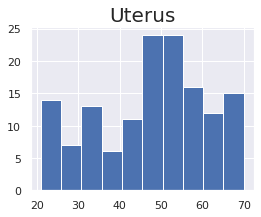

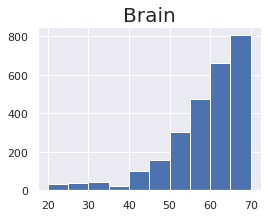

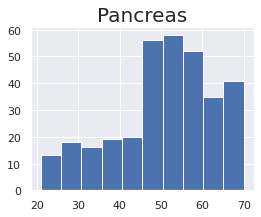

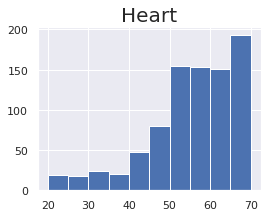

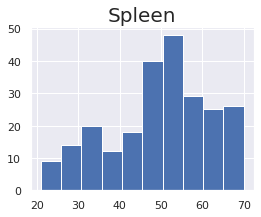

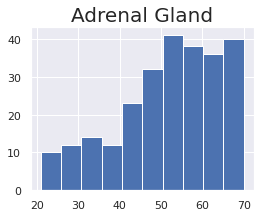

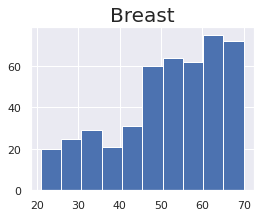

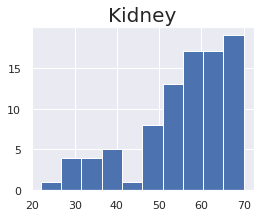

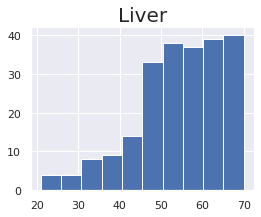

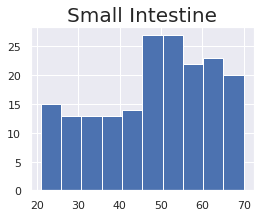

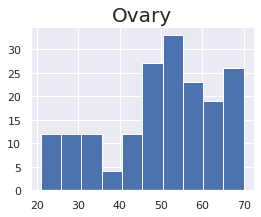

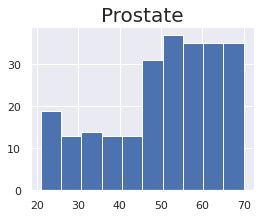

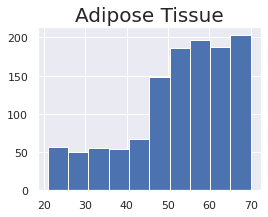

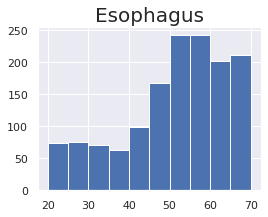

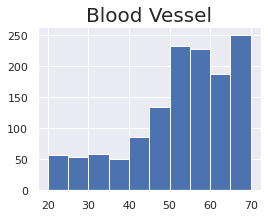

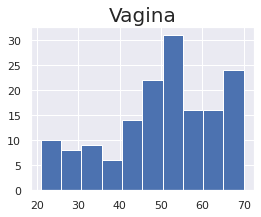

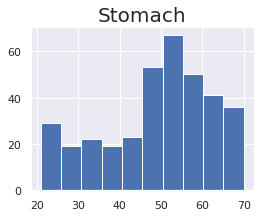

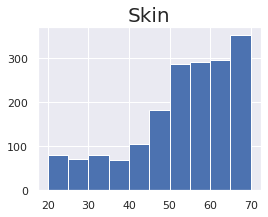

In [92]:
for tissue in tissues:
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.hist(age[tissue])
    ax.set_title(tissue, fontsize=title_fontsize)